In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb

In [2]:
def load_and_preprocess_data(train_path, test_path):
    """Load and preprocess data properly"""
    # Load data
    train_df = pd.read_csv(train_path, low_memory=False)
    test_df = pd.read_csv(test_path, low_memory=False)
    
    # Combine for preprocessing consistency
    full_df = pd.concat([train_df, test_df], ignore_index=True)
    
    # Filter out missing targets
    full_df = full_df[full_df['saleEstimate_currentPrice'].notnull()]
    
    # Basic cleaning
    full_df = full_df[full_df['saleEstimate_currentPrice'] > 10000]  # Remove unrealistic prices
    full_df = full_df[full_df['floorAreaSqM'] > 20]  # Remove unrealistic sizes
    
    # Handle missing values
    full_df['bathrooms'] = full_df['bathrooms'].fillna(full_df['bathrooms'].median())
    full_df['bedrooms'] = full_df['bedrooms'].fillna(full_df['bedrooms'].median())
    full_df['livingRooms'] = full_df['livingRooms'].fillna(full_df['livingRooms'].median())
    full_df['currentEnergyRating'] = full_df['currentEnergyRating'].fillna('Unknown')
    
    # Convert confidence level
    conf_levels = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2}
    full_df['saleEstimate_confidenceLevel'] = full_df['saleEstimate_confidenceLevel'].map(conf_levels)
    
    # Feature engineering (without data leakage)
    full_df['room_count'] = full_df['bedrooms'] + full_df['bathrooms'] + full_df['livingRooms']
    full_df['bed_bath_ratio'] = full_df['bedrooms'] / (full_df['bathrooms'] + 0.01)  # Avoid division by zero
    
    # Split back to train and test
    train_size = len(train_df)
    train_df_clean = full_df.iloc[:train_size]
    test_df_clean = full_df.iloc[train_size:]
    
    return train_df_clean, test_df_clean, full_df

In [3]:
def select_features(df):
    """Select features without data leakage"""
    features = [
        'latitude', 'longitude',
        'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
        'propertyType', 'currentEnergyRating',
        'saleEstimate_confidenceLevel',
        'room_count', 'bed_bath_ratio'
    ]
    
    target = 'saleEstimate_currentPrice'
    
    X = df[features]
    y = df[target]
    
    return X, y, features, target

In [4]:
def train_ensemble_models(X_train, y_train):
    """Train multiple ensemble models and return the best one"""
    
    # Define features
    numeric_features = [
        'latitude', 'longitude', 'bathrooms', 'bedrooms', 
        'floorAreaSqM', 'livingRooms', 'saleEstimate_confidenceLevel',
        'room_count', 'bed_bath_ratio'
    ]
    
    categorical_features = ['propertyType', 'currentEnergyRating']
    
    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define multiple ensemble models
    models = {
        'LightGBM': lgb.LGBMRegressor(
            random_state=42, n_estimators=1000, learning_rate=0.05,
            max_depth=7, subsample=0.8, colsample_bytree=0.8, verbose=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            random_state=42, n_estimators=1000, learning_rate=0.05,
            max_depth=7, subsample=0.8, colsample_bytree=0.8
        ),
        'RandomForest': RandomForestRegressor(
            n_estimators=200, random_state=42, max_depth=15,
            min_samples_split=5, n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=500, random_state=42, learning_rate=0.05,
            max_depth=5, subsample=0.8
        )
    }
    
    model_results = {}
    print("\nTraining ensemble models...")
    
    for name, model in models.items():
        try:
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])
            
            # Cross-validation
            cv_scores = cross_val_score(
                pipeline, X_train, y_train,
                cv=3, scoring='neg_root_mean_squared_error',
                n_jobs=-1
            )
            cv_rmse = -cv_scores.mean()
            
            # Store results
            model_results[name] = {
                'pipeline': pipeline,
                'cv_rmse': cv_rmse
            }
            
            print(f"{name}: CV RMSE = £{cv_rmse:,.2f}")
            
        except Exception as e:
            print(f"{name}: Failed - {e}")
    
    return model_results

In [5]:
def create_stacking_ensemble(model_results, X_train, y_train):
    """Create a stacking ensemble from the trained models"""
    
    # Get predictions from all models for stacking
    meta_features = []
    model_pipelines = {}
    
    print("\nTraining stacking ensemble...")
    
    for name, result in model_results.items():
        print(f"Training {name} for stacking...")
        pipeline = result['pipeline']
        pipeline.fit(X_train, y_train)
        model_pipelines[name] = pipeline
        meta_features.append(pipeline.predict(X_train))
    
    # Create meta-features matrix
    X_meta = np.column_stack(meta_features)
    
    # Train meta-model
    meta_model = LinearRegression()
    meta_model.fit(X_meta, y_train)
    
    return model_pipelines, meta_model

In [6]:
def stacking_predict(model_pipelines, meta_model, X):
    """Make predictions using stacking ensemble"""
    meta_features = []
    for name, pipeline in model_pipelines.items():
        meta_features.append(pipeline.predict(X))
    
    X_meta = np.column_stack(meta_features)
    return meta_model.predict(X_meta)

In [7]:
def save_test_predictions(pipeline, X_test, y_test, original_test_df, save_path):
    """Save predictions with original test data for comparison"""
    
    # Make predictions
    print("Making predictions on test data...")
    y_pred = pipeline.predict(X_test)
    
    # Create results dataframe
    results_df = original_test_df.copy()
    results_df['predicted_price'] = y_pred
    results_df['prediction_error'] = results_df['saleEstimate_currentPrice'] - results_df['predicted_price']
    results_df['absolute_error'] = np.abs(results_df['prediction_error'])
    results_df['percentage_error'] = (results_df['absolute_error'] / results_df['saleEstimate_currentPrice']) * 100
    
    # Add useful columns for analysis
    results_df = results_df[[
        'latitude', 'longitude', 'bedrooms', 'bathrooms', 'floorAreaSqM', 'livingRooms',
        'propertyType', 'currentEnergyRating', 'saleEstimate_confidenceLevel',
        'saleEstimate_currentPrice', 'predicted_price', 'prediction_error',
        'absolute_error', 'percentage_error'
    ]]
    
    # Save to CSV
    predictions_path = f'{save_path}/test_predictions_detailed.csv'
    results_df.to_csv(predictions_path, index=False)
    print(f"Detailed predictions saved to: {predictions_path}")
    
    return results_df

In [8]:
def generate_comprehensive_visualizations(df_all, features, target, model_pipelines):
    """Generate comprehensive EDA and model visualizations"""
    
    print("\n11. Generating comprehensive visualizations...")
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. Distribution of Sale Prices
    plt.figure(figsize=(10, 6))
    sns.histplot(df_all['saleEstimate_currentPrice'], kde=True, bins=50)
    plt.title("Distribution of Sale Prices", fontsize=14, fontweight='bold')
    plt.xlabel("Sale Price (£)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Sale Price vs. Floor Area (colored by bedrooms)
    plt.figure(figsize=(10, 6))
    sample_df = df_all.sample(5000) if len(df_all) > 5000 else df_all
    sns.scatterplot(
        data=sample_df,
        x='floorAreaSqM',
        y='saleEstimate_currentPrice',
        hue='bedrooms',
        palette='viridis',
        alpha=0.6,
        s=30
    )
    plt.title("Sale Price vs. Floor Area (SqM)", fontsize=14, fontweight='bold')
    plt.xlabel("Floor Area (SqM)", fontsize=12)
    plt.ylabel("Sale Price (£)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 3. Historical Price Trend (FIXED - handle missing/incorrect dates)
    try:
        # Ensure history_date is datetime
        df_filtered = df_all.dropna(subset=['history_date', 'history_price']).copy()
        df_filtered['history_date'] = pd.to_datetime(df_filtered['history_date'], errors='coerce')
        df_filtered = df_filtered.dropna(subset=['history_date'])
        
        df_filtered = df_filtered[(df_filtered['history_price'] > 0) & 
                                 (df_filtered['history_price'] < 3_000_000)]
        
        if len(df_filtered) > 0:
            df_filtered['history_month'] = df_filtered['history_date'].dt.to_period('M').dt.to_timestamp()
            monthly_avg = df_filtered.groupby('history_month')['history_price'].mean().reset_index()

            plt.figure(figsize=(12, 6))
            sns.lineplot(data=monthly_avg, x='history_month', y='history_price', color='blue', linewidth=2)
            plt.title("Monthly Average Historical Price Trend", fontsize=14, fontweight='bold')
            plt.xlabel("Date", fontsize=12)
            plt.ylabel("Average Price (£)", fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("Skipping historical price trend - no valid date data")
    except Exception as e:
        print(f"Could not generate historical trend: {e}")
    
    # 4. Correlation Heatmap
    plt.figure(figsize=(12, 10))
    numeric_features = [f for f in features if df_all[f].dtype in ['int64', 'float64']]
    corr = df_all[numeric_features + [target]].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title("Correlation Heatmap of Features", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 5. Sale Price by Property Type
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='propertyType',
        y='saleEstimate_currentPrice',
        data=df_all,
        showfliers=False  # Remove outliers for better visualization
    )
    plt.title("Sale Price Distribution by Property Type", fontsize=14, fontweight='bold')
    plt.xlabel("Property Type", fontsize=12)
    plt.ylabel("Sale Price (£)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 6. Average Sale Price by Bedroom Count
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='bedrooms',
        y='saleEstimate_currentPrice',
        data=df_all,
        estimator=np.mean,
        palette='Set2',
        errorbar=None
    )
    plt.title("Average Sale Price by Bedroom Count", fontsize=14, fontweight='bold')
    plt.xlabel("Bedrooms", fontsize=12)
    plt.ylabel("Average Sale Price (£)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 7. Geographic Distribution of Sale Prices
    plt.figure(figsize=(12, 8))
    sample_geo = df_all.sample(1000) if len(df_all) > 1000 else df_all
    scatter = sns.scatterplot(
        x='longitude',
        y='latitude',
        size='saleEstimate_currentPrice',
        hue='saleEstimate_currentPrice',
        data=sample_geo,
        sizes=(20, 200),
        palette='viridis',
        alpha=0.7
    )
    plt.title("Geographic Distribution of Sale Prices", fontsize=14, fontweight='bold')
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.legend(title='Sale Price (£)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 8. Pairplot of Key Features
    pairplot_cols = ['saleEstimate_currentPrice', 'floorAreaSqM', 'bedrooms', 'bathrooms']
    sample_pairplot = df_all[pairplot_cols].dropna().sample(1000) if len(df_all) > 1000 else df_all[pairplot_cols].dropna()
    
    pairplot = sns.pairplot(
        sample_pairplot,
        diag_kind='kde',
        plot_kws={'alpha': 0.6},
        height=3
    )
    pairplot.fig.suptitle("Pairwise Relationships Between Key Features", y=1.02, fontsize=14, fontweight='bold')
    plt.show()
    
    # 9. Feature Importance (using the best model from ensemble)
    try:
        # Get the best single model (XGBoost based on your results)
        best_model_name = 'XGBoost'  # Or use the best from your results
        if best_model_name in model_pipelines:
            best_pipeline = model_pipelines[best_model_name]
            
            if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
                importances = best_pipeline.named_steps['model'].feature_importances_
                
                # Get feature names from preprocessor
                numeric_features = [
                    'latitude', 'longitude', 'bathrooms', 'bedrooms', 
                    'floorAreaSqM', 'livingRooms', 'saleEstimate_confidenceLevel',
                    'room_count', 'bed_bath_ratio'
                ]
                
                categorical_features = ['propertyType', 'currentEnergyRating']
                preprocessor = best_pipeline.named_steps['preprocessor']
                
                # Get categorical feature names
                cat_transformer = preprocessor.named_transformers_['cat']
                if hasattr(cat_transformer, 'named_steps') and 'onehot' in cat_transformer.named_steps:
                    ohe = cat_transformer.named_steps['onehot']
                    cat_feature_names = ohe.get_feature_names_out(categorical_features)
                else:
                    cat_feature_names = categorical_features
                
                all_feature_names = numeric_features + list(cat_feature_names)
                
                importance_df = pd.DataFrame({
                    'Feature': all_feature_names,
                    'Importance': importances
                }).sort_values('Importance', ascending=False).head(15)
                
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
                plt.title(f"Top 15 Feature Importances ({best_model_name})", fontsize=14, fontweight='bold')
                plt.xlabel('Importance Score', fontsize=12)
                plt.ylabel('Feature', fontsize=12)
                plt.tight_layout()
                plt.show()
                
    except Exception as e:
        print(f"Could not generate feature importance plot: {e}")

In [9]:
if __name__ == "__main__":
    # Configuration
    train_path = '/Users/zainabmushtaq/predicting-house-prices/backend/kaggle_london_house_price_data_train.csv'
    test_path = '/Users/zainabmushtaq/predicting-house-prices/backend/kaggle_london_house_price_data_test.csv'
    save_path = '/Users/zainabmushtaq/predicting-house-prices/backend'
    
    print("=== LONDON HOUSE PRICE PREDICTION MODEL ===")

=== LONDON HOUSE PRICE PREDICTION MODEL ===


In [10]:
# 1. Load and preprocess data
print("\n1. Loading and preprocessing data...")
train_df, test_df, full_df = load_and_preprocess_data(train_path, test_path)



1. Loading and preprocessing data...


In [11]:
# 2. Select features
print("2. Selecting features...")
X_train, y_train, features, target = select_features(train_df)
X_test, y_test, _, _ = select_features(test_df)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {len(features)}")

2. Selecting features...
Training set: 418201 samples
Test set: 169378 samples
Features: 11


In [12]:
# 3. Train ensemble models
print("3. Training ensemble models...")
model_results = train_ensemble_models(X_train, y_train)


3. Training ensemble models...

Training ensemble models...
LightGBM: CV RMSE = £251,156.72
XGBoost: CV RMSE = £217,184.62
RandomForest: CV RMSE = £230,415.19
GradientBoosting: CV RMSE = £277,190.39


In [13]:
# 4. Create stacking ensemble
print("4. Creating stacking ensemble...")
model_pipelines, meta_model = create_stacking_ensemble(model_results, X_train, y_train)

4. Creating stacking ensemble...

Training stacking ensemble...
Training LightGBM for stacking...
Training XGBoost for stacking...
Training RandomForest for stacking...
Training GradientBoosting for stacking...


In [14]:
# 5. Evaluate stacking ensemble
print("5. Evaluating stacking ensemble...")

# Make predictions with stacking
y_pred_stacking = stacking_predict(model_pipelines, meta_model, X_test)
y_pred_train_stacking = stacking_predict(model_pipelines, meta_model, X_train)

# Calculate metrics
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

rmse_train_stacking = np.sqrt(mean_squared_error(y_train, y_pred_train_stacking))

print(f"\n=== STACKING ENSEMBLE PERFORMANCE ===")
print(f"Test RMSE: £{rmse_stacking:,.2f}")
print(f"Test MAE: £{mae_stacking:,.2f}")
print(f"Test R²: {r2_stacking:.4f}")
print(f"Train RMSE: £{rmse_train_stacking:,.2f}")
print(f"RMSE Ratio (test/train): {rmse_stacking/rmse_train_stacking:.3f}")

5. Evaluating stacking ensemble...

=== STACKING ENSEMBLE PERFORMANCE ===
Test RMSE: £137,795.86
Test MAE: £79,177.14
Test R²: 0.9750
Train RMSE: £138,774.36
RMSE Ratio (test/train): 0.993


In [15]:
# 6. Compare with best single model
best_single_name = min(model_results, key=lambda k: model_results[k]['cv_rmse'])
best_single_rmse = model_results[best_single_name]['cv_rmse']
print(f"\nBest single model ({best_single_name}): £{best_single_rmse:,.2f}")
print(f"Stacking ensemble: £{rmse_stacking:,.2f}")
print(f"Improvement: {((best_single_rmse - rmse_stacking) / best_single_rmse * 100):.1f}%")


Best single model (XGBoost): £217,184.62
Stacking ensemble: £137,795.86
Improvement: 36.6%


In [16]:
# 7. Save the entire ensemble
print("7. Saving ensemble model...")
ensemble_data = {
    'model_pipelines': model_pipelines,
    'meta_model': meta_model,
    'feature_names': features
}

ensemble_path = f'{save_path}/best_house_price_pipeline.pkl'
joblib.dump(ensemble_data, ensemble_path)
print(f"Ensemble model saved to: {ensemble_path}")

7. Saving ensemble model...
Ensemble model saved to: /Users/zainabmushtaq/predicting-house-prices/backend/best_house_price_pipeline.pkl


In [17]:
# 8. Save test predictions
print("8. Saving test predictions...")

# Create a wrapper class for the stacking ensemble
class StackingEnsemble:
    def __init__(self, model_pipelines, meta_model):
        self.model_pipelines = model_pipelines
        self.meta_model = meta_model

    def predict(self, X):
        return stacking_predict(self.model_pipelines, self.meta_model, X)

# Create the ensemble predictor
ensemble_predictor = StackingEnsemble(model_pipelines, meta_model)

test_predictions = save_test_predictions(
    ensemble_predictor,
    X_test, y_test, test_df, save_path
)

8. Saving test predictions...
Making predictions on test data...
Detailed predictions saved to: /Users/zainabmushtaq/predicting-house-prices/backend/test_predictions_detailed.csv


In [18]:
# 9. Make sample prediction
print("\n9. Sample prediction:")
sample_data = {
    'latitude': 51.5074,
    'longitude': -0.1278,
    'bathrooms': 2,
    'bedrooms': 3,
    'floorAreaSqM': 100,
    'livingRooms': 1,
    'propertyType': 'Purpose Built Flat',
    'currentEnergyRating': 'C',
    'saleEstimate_confidenceLevel': 2,
    'room_count': 6,
    'bed_bath_ratio': 1.5
}

sample_df = pd.DataFrame([sample_data])
prediction = stacking_predict(model_pipelines, meta_model, sample_df)[0]
print(f"Predicted price for sample property: £{prediction:,.2f}")


9. Sample prediction:
Predicted price for sample property: £1,551,171.55


In [19]:
# 10. Show some prediction examples
print("\n10. Sample test predictions:")
sample_results = test_predictions.head(10)[[
    'bedrooms', 'bathrooms', 'floorAreaSqM',
    'saleEstimate_currentPrice', 'predicted_price', 'percentage_error'
]]
print(sample_results.round(2))

print("\n=== ENSEMBLE TRAINING COMPLETE ===")


10. Sample test predictions:
        bedrooms  bathrooms  floorAreaSqM  saleEstimate_currentPrice  \
446466       2.0        3.0          72.0                  1058000.0   
446467       4.0        2.0         162.0                  1096000.0   
446468       3.0        1.0         104.0                   646000.0   
446469       2.0        1.0          70.0                   511000.0   
446470       2.0        1.0          57.0                   400000.0   
446472       1.0        1.0          41.0                   752000.0   
446473       1.0        1.0          51.0                   639000.0   
446474       2.0        1.0          78.0                   768000.0   
446475       3.0        1.0          98.0                   400000.0   
446476       3.0        2.0         112.0                  1008000.0   

        predicted_price  percentage_error  
446466        813429.92             23.12  
446467       1007927.28              8.04  
446468        790356.51             22.35  
4


11. Generating comprehensive visualizations...


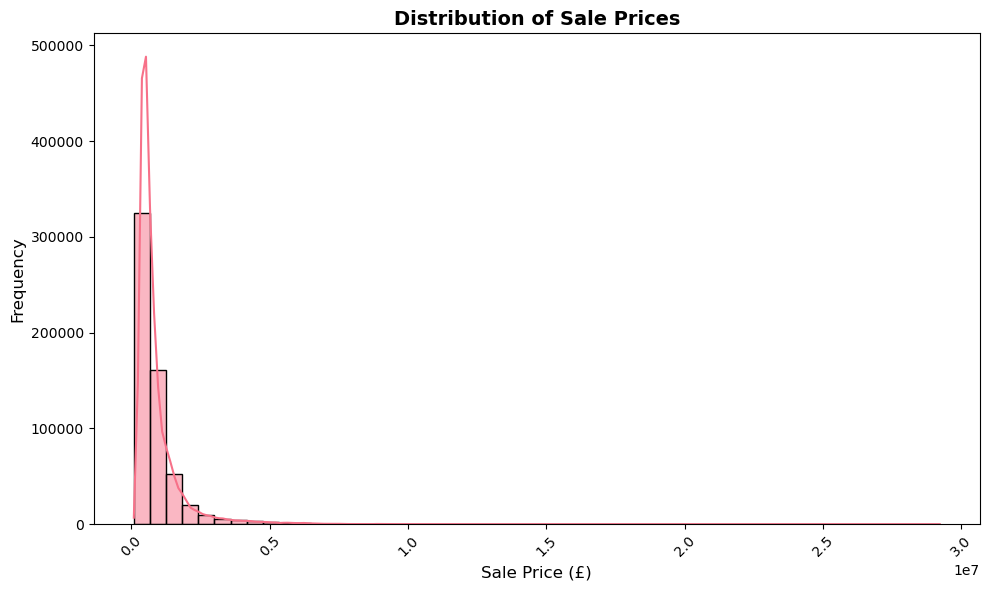

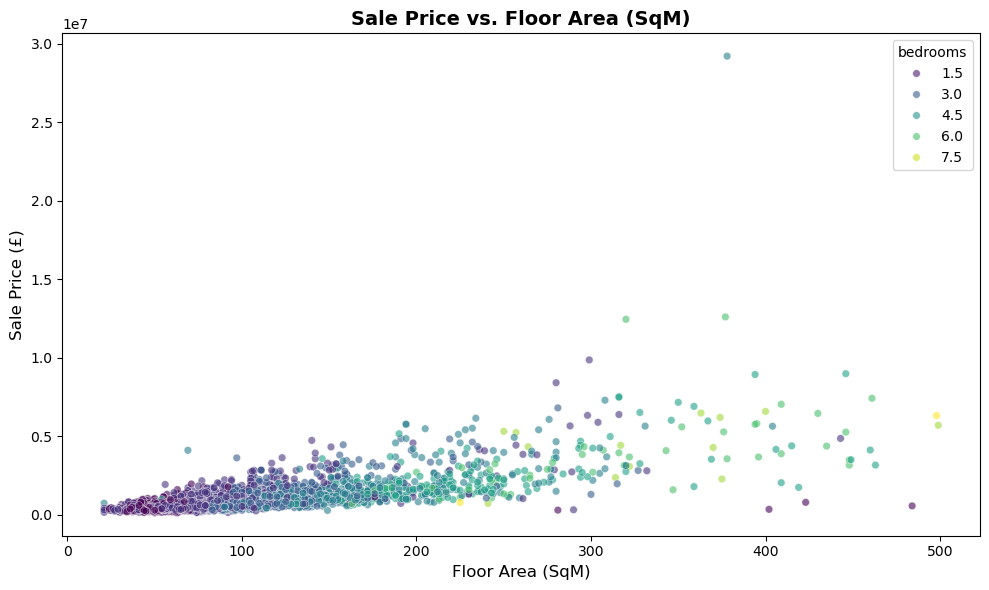

/var/folders/98/75txd77s6mn74pw5_g14cdx80000gn/T/ipykernel_86875/2382662096.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_filtered['history_date'] = pd.to_datetime(df_filtered['history_date'], errors='coerce')


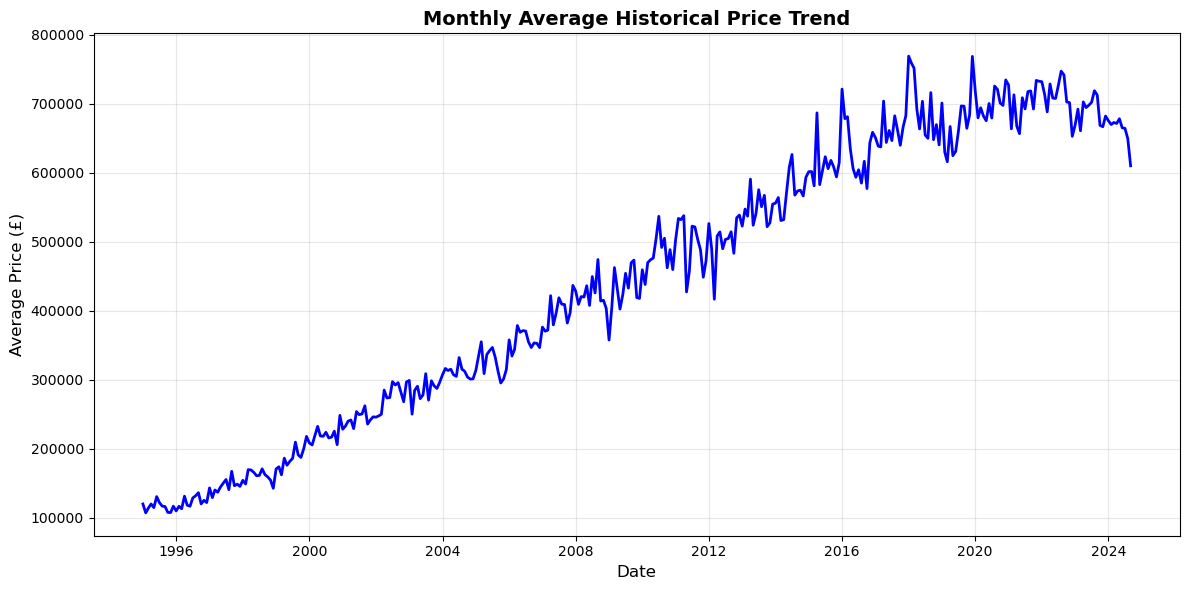

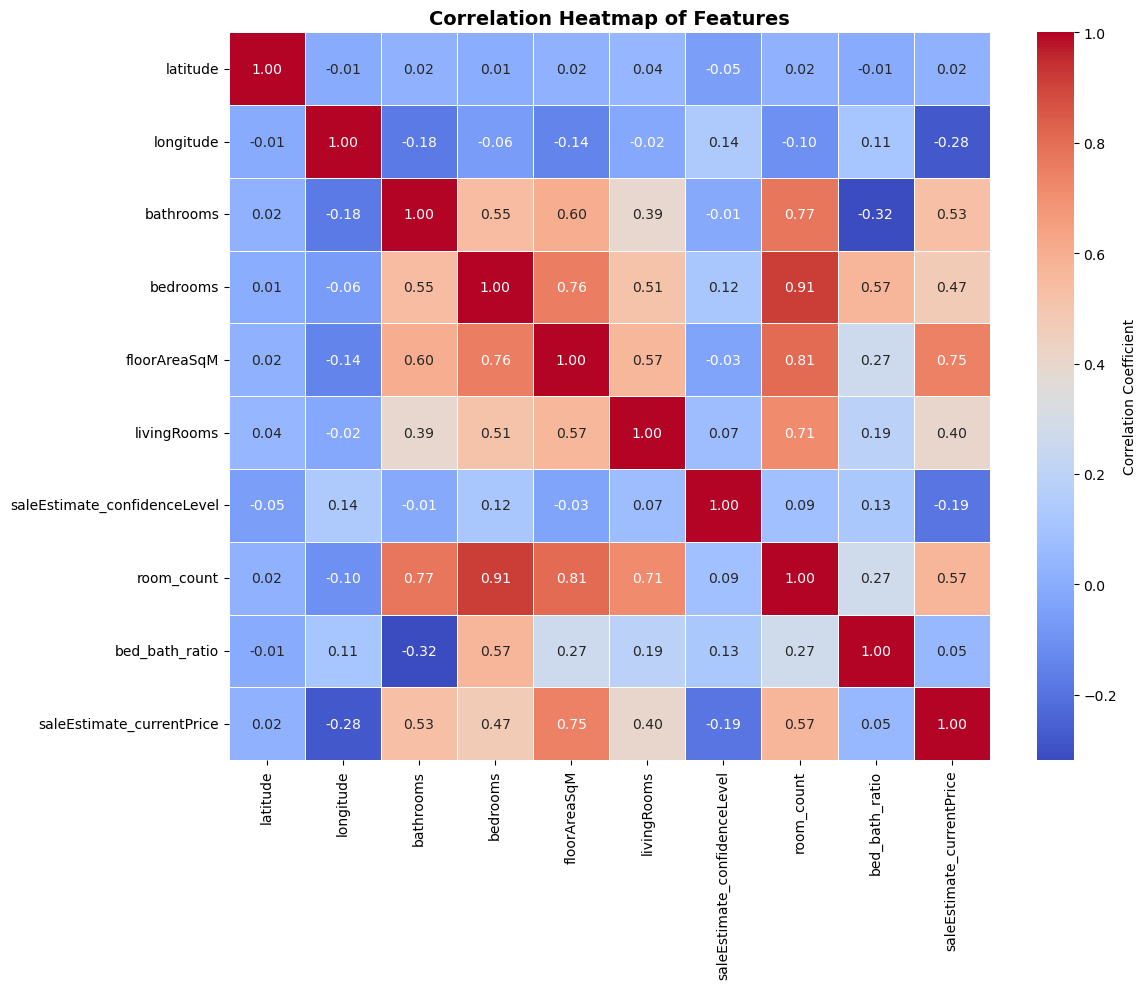

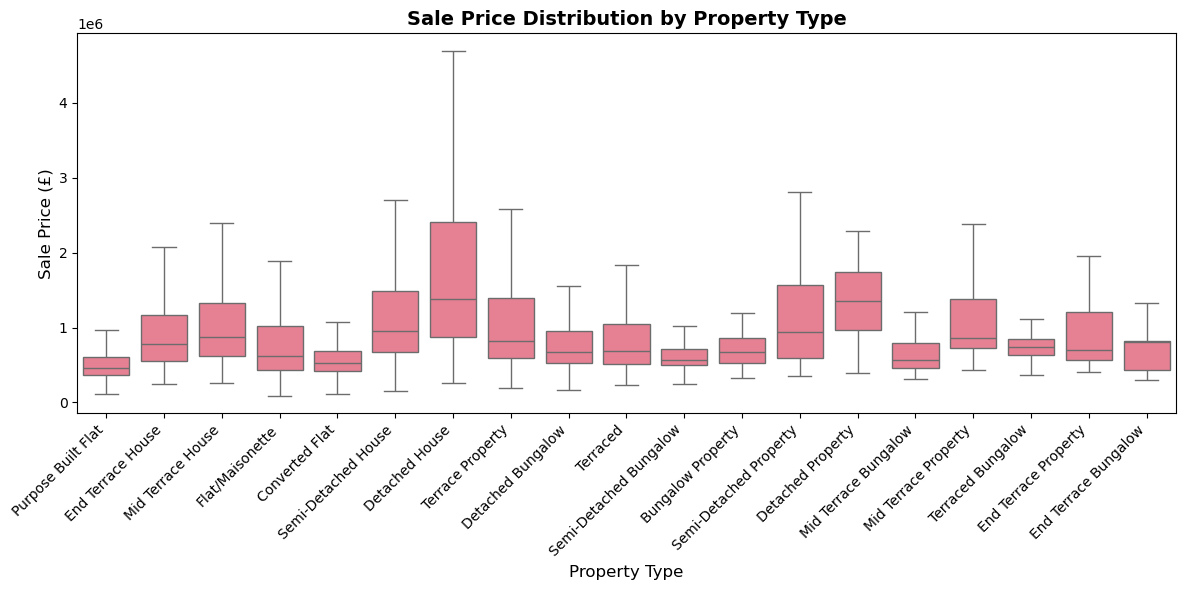

/var/folders/98/75txd77s6mn74pw5_g14cdx80000gn/T/ipykernel_86875/2382662096.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


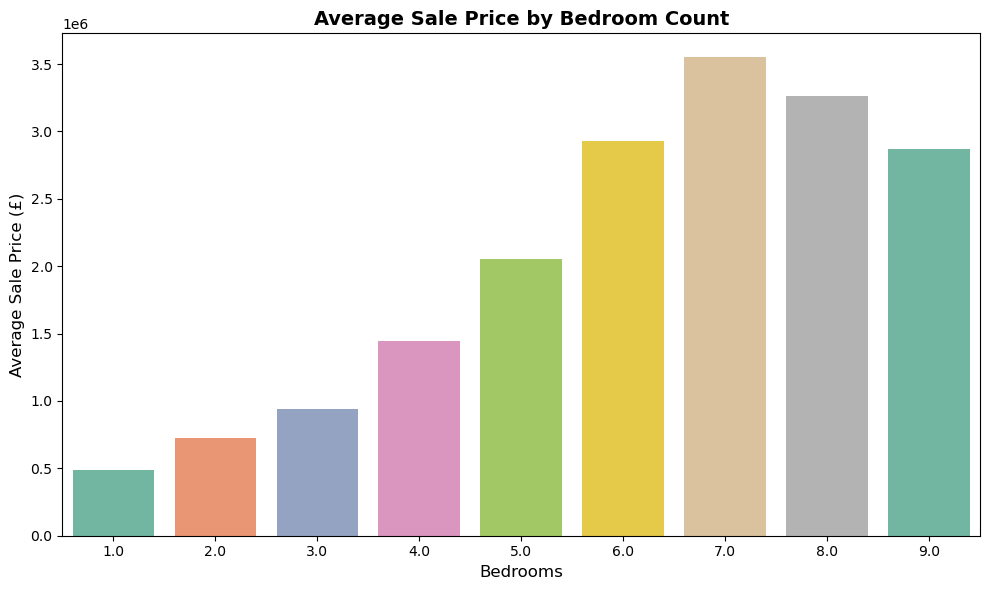

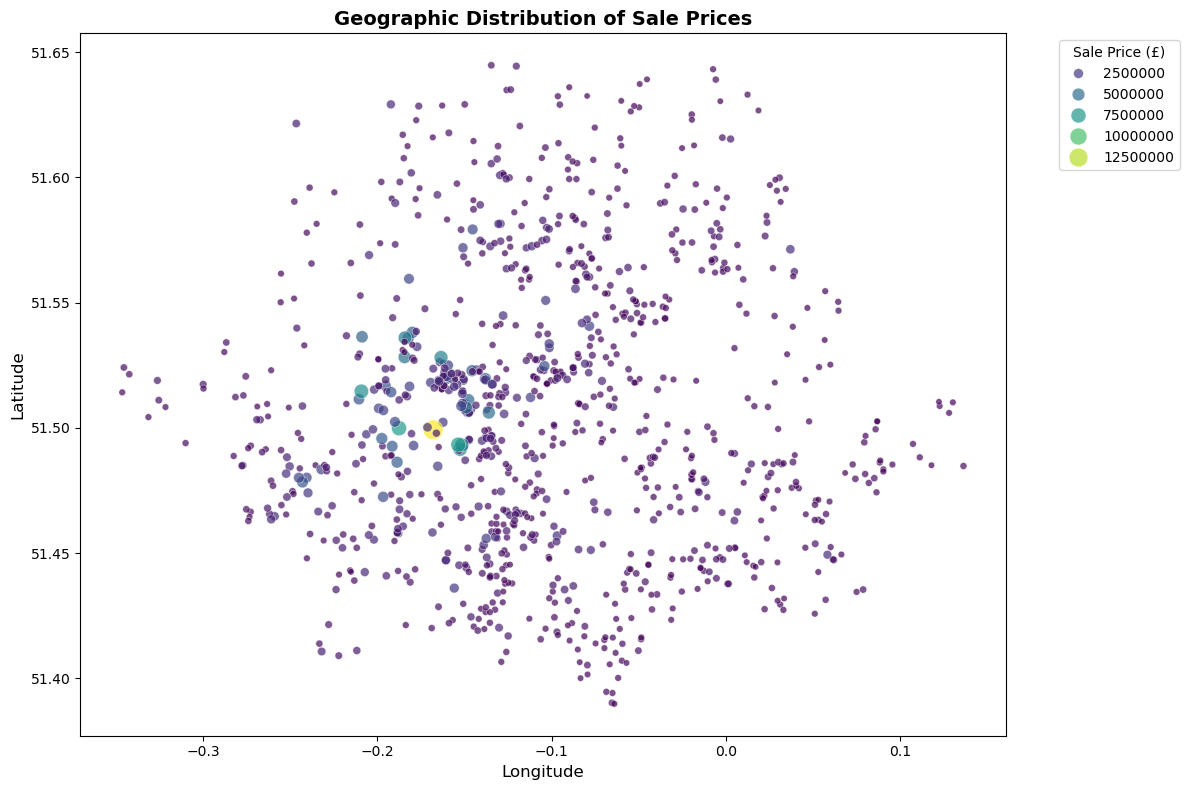

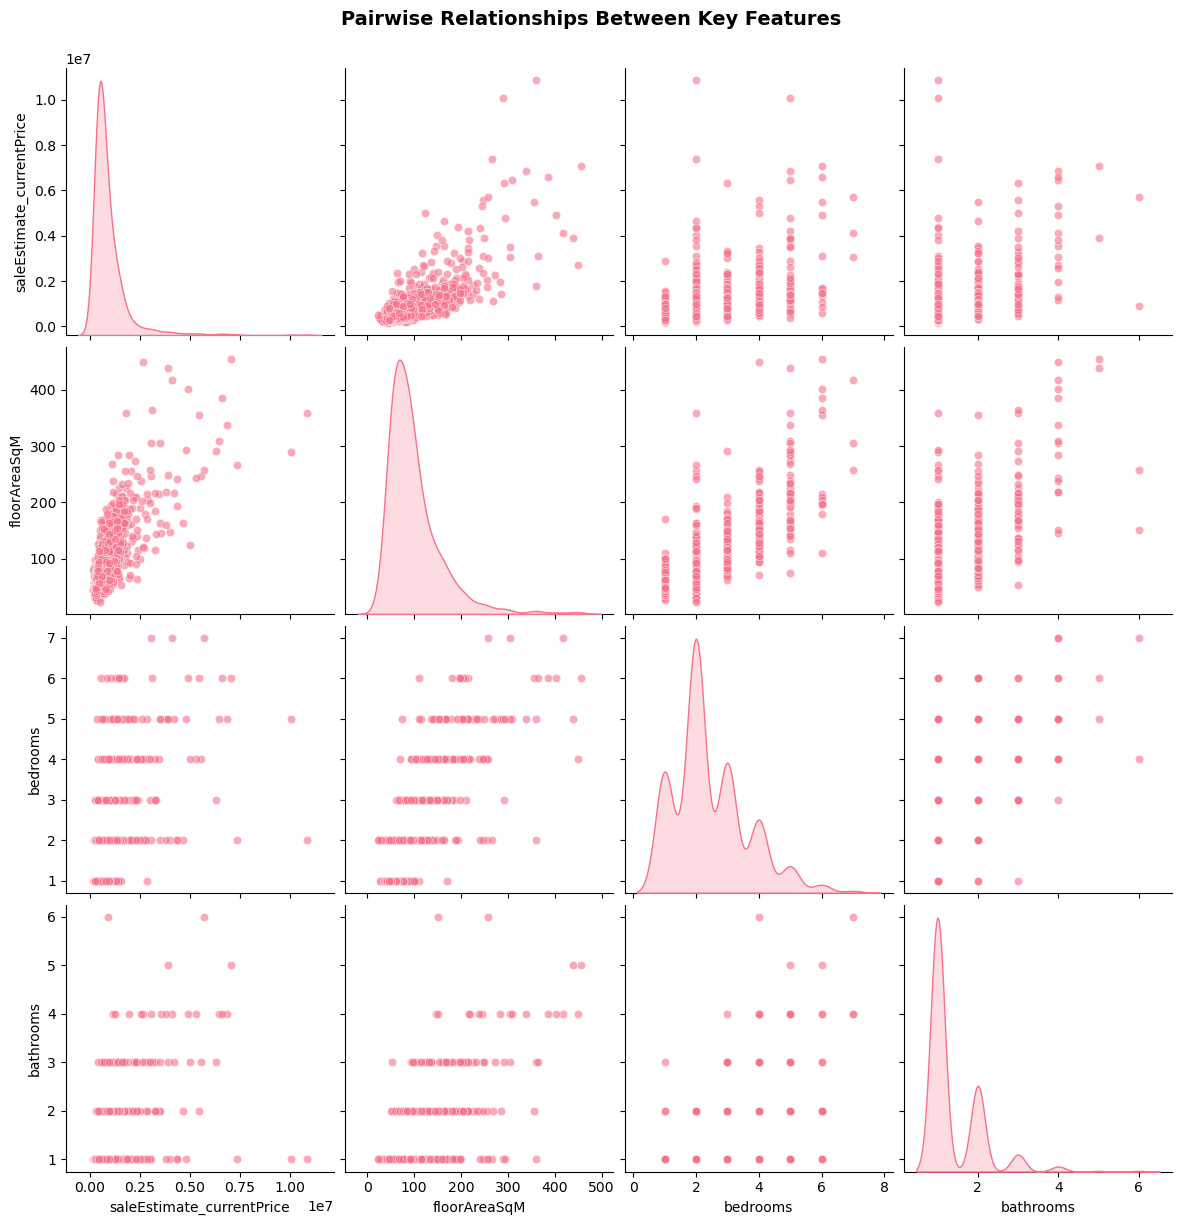

/var/folders/98/75txd77s6mn74pw5_g14cdx80000gn/T/ipykernel_86875/2382662096.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')


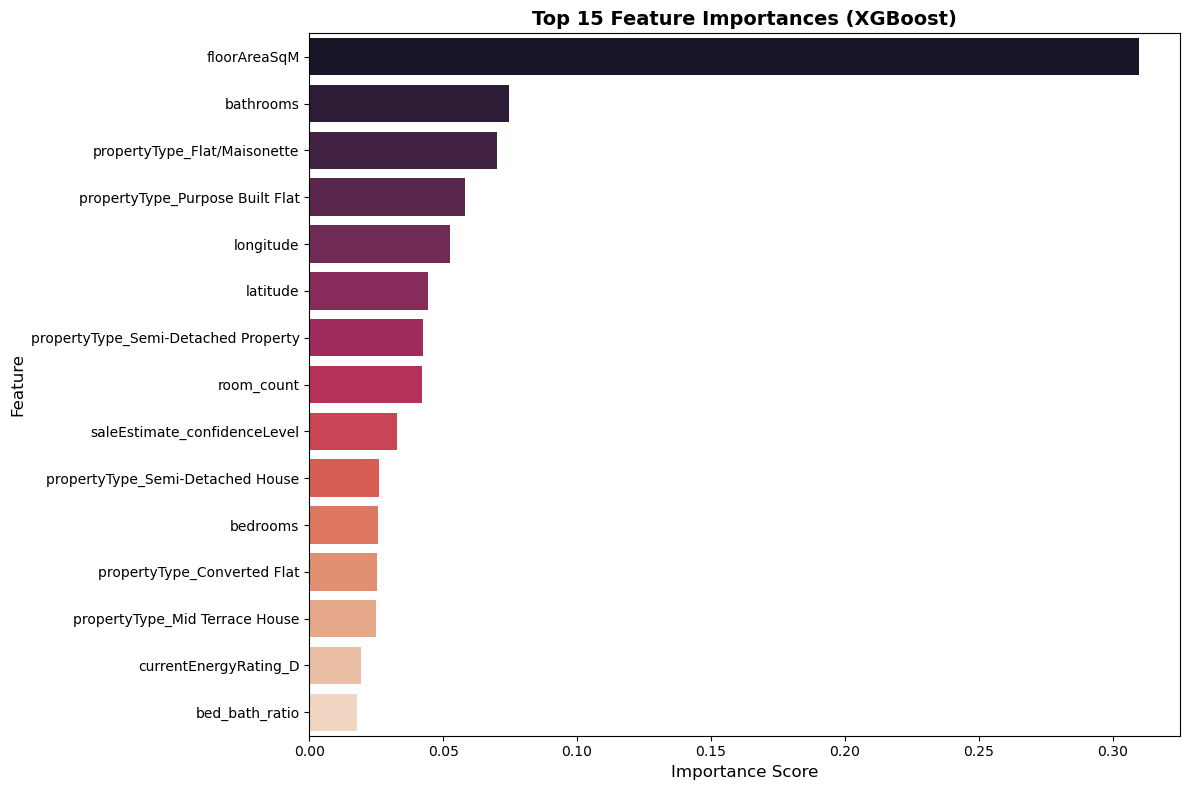

In [20]:
# 11. Generate comprehensive visualizations
generate_comprehensive_visualizations(full_df, features, target, model_pipelines)